## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List
from tqdm import tqdm

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy, read_each_loader
from optimization.functions import convert_sample_2_df, trajectory_estimation, find_indices_of_trajectory_changes

from models.policy_model import RobotPolicy

In [2]:
pd.set_option("display.max_columns",
              None)

# Initialization

In [3]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory,
                                           data_folder_name=constants.TEST_COLLECTION_DATE)

Evaluating Device:  cpu
Current Time:  Feb_06_2024-10_16_55


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load test demonstrations dataset
all_test_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  5
Each Trajectory Length:  30
Full Demo Dataset Size:  163


In [6]:
validation_loader = torch.utils.data.DataLoader(all_test_data,
                                                batch_size=1,
                                                shuffle=False,
                                                num_workers=configs.num_workers)

# Functions

In [7]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

In [8]:
def plot_label_estim_state(axs: List[plt.Axes],
                           colors: List[str],
                           state_number_series: pd.Series,
                           label_data_df: pd.DataFrame,
                           estim_data_df: pd.DataFrame):
    
    if not isinstance(axs, list):
        raise TypeError("Input 'axs' in plot_label_estim_state function must be a list.")
    if not all(isinstance(ax, plt.Axes) for ax in axs):
        raise TypeError("All elements in 'axs' must be instances of matplotlib.axes._subplots.AxesSubplot.")
    if not isinstance(colors, list):
        raise TypeError("Input 'colors' in plot_label_estim_state function must be a list.")
    if not all(isinstance(color, str) for color in colors):
        raise TypeError("All elements in 'colors' must be strings representing colors.")
    if not isinstance(state_number_series, pd.Series):
        raise TypeError("Input 'state_number_series' in plot_label_estim_state function must be a pandas Series.")
    if not isinstance(label_data_df, pd.DataFrame):
        raise TypeError("Input 'label_data_df' in plot_label_estim_state function must be a pandas DataFrame.")
    if not isinstance(estim_data_df, pd.DataFrame):
        raise TypeError("Input 'estim_data_df' in plot_label_estim_state function must be a pandas DataFrame.")
    
    label_distance_to_object = label_data_df.iloc[:, 0]
    label_distance_to_target = label_data_df.iloc[:, 1]
    label_distance_to_start = label_data_df.iloc[:, 2]
    label_distance_to_ground = label_data_df.iloc[:, 3]
    
    estim_distance_to_object = estim_data_df.iloc[:, 0]
    estim_distance_to_target = estim_data_df.iloc[:, 1]
    estim_distance_to_start = estim_data_df.iloc[:, 2]
    estim_distance_to_ground = estim_data_df.iloc[:, 3]
    
    if len(axs) == 1:
        axs[0].plot(state_number_series, label_distance_to_start,
                    color=colors[0],
                    label="Label: Distance to Start")
        axs[0].plot(state_number_series, estim_distance_to_start,
                    color=colors[4],
                    linestyle="--",
                    label="Estimation: Distance to Start")
        
        axs[0].plot(state_number_series, label_distance_to_target,
                    color=colors[1],
                    label="Label: Distance to Target")
        axs[0].plot(state_number_series, estim_distance_to_target,
                    color=colors[5],
                    linestyle="--",
                    label="Estimation: Distance to Target")
        
        axs[0].plot(state_number_series, label_distance_to_object,
                    color=colors[2],
                    label="Label: Distance to Obstacle")
        axs[0].plot(state_number_series, estim_distance_to_object,
                    color=colors[6],
                    linestyle="--",
                    label="Estimation: Distance to Obstacle")
        
        axs[0].plot(state_number_series, label_distance_to_ground,
                    color=colors[3],
                    label="Distance to Ground")
        axs[0].plot(state_number_series, estim_distance_to_ground,
                    color=colors[7],
                    linestyle="--",
                    label="Estimation: Distance to Ground")
    
    else:
        axs[0].plot(state_number_series, label_distance_to_start,
                    color=colors[0])
        axs[0].set_title("Distance to Start")
        axs[1].plot(state_number_series, label_distance_to_target,
                    color=colors[1])
        axs[1].set_title("Distance to Target")
        axs[2].plot(state_number_series, label_distance_to_object,
                    color=colors[2])
        axs[2].set_title("Distance to Obstacle")
        axs[3].plot(state_number_series, label_distance_to_ground,
                    color=colors[3])
        axs[3].set_title("Distance to Ground")
        
        axs[0].plot(state_number_series, estim_distance_to_start,
                    color=colors[4],
                    linestyle="--")
        axs[1].plot(state_number_series, estim_distance_to_target,
                    color=colors[5],
                    linestyle="--")
        axs[2].plot(state_number_series, estim_distance_to_object,
                    color=colors[6],
                    linestyle="--")
        axs[3].plot(state_number_series, estim_distance_to_ground,
                    color=colors[7],
                    linestyle="--")

In [9]:
def plot_trajectory(ax: plt.Axes,
                    label_trajectory_df: pd.DataFrame,
                    estim_trajectory_df: pd.DataFrame,
                    object_position: List[float],
                    colors: List[str],
                    traj_s: int,
                    start_s: int,
                    end_s: int):
    
    if not isinstance(ax, plt.Axes):
        raise TypeError("Input 'ax' must be an instance of matplotlib Axes.")
    if not isinstance(label_trajectory_df, pd.DataFrame) or not isinstance(estim_trajectory_df, pd.DataFrame):
        raise TypeError("Input 'label_trajectory_df' and 'estim_trajectory_df' must be pandas DataFrames.")
    if not isinstance(colors, list):
        raise TypeError("Input 'colors' in plot_trajectory function must be a list.")
    if not all(isinstance(color, str) for color in colors):
        raise TypeError("All elements in 'colors' must be strings representing colors.")
    
    start_index = 0
    end_index = -1
    
    x_label = label_trajectory_df.iloc[:, 0]
    y_label = label_trajectory_df.iloc[:, 1]
    z_label = label_trajectory_df.iloc[:, 2]
    
    x_estim = estim_trajectory_df.iloc[:, 0]
    y_estim = estim_trajectory_df.iloc[:, 1]
    z_estim = estim_trajectory_df.iloc[:, 2]
    
    if not isinstance(x_label, pd.Series) or not isinstance(y_label, pd.Series) or not isinstance(z_label, pd.Series):
        raise TypeError("Columns of 'label_trajectory_df' must be pandas Series.")
    if not isinstance(x_estim, pd.Series) or not isinstance(y_estim, pd.Series) or not isinstance(z_estim, pd.Series):
        raise TypeError("Columns of 'estim_trajectory_df' must be pandas Series.")
    
    scatter_traj = ax.scatter(x_label, y_label, z_label,
                              c=colors[0], marker="o", s=traj_s, label="Human Demonstration")
    scatter_traj = ax.scatter(x_estim, y_estim, z_estim,
                              c=colors[1], marker="o", s=traj_s, label="Robot Execution")
    
    scatter_start = ax.scatter(x_label.iloc[start_index], y_label.iloc[start_index], z_label.iloc[start_index],
                               c="green", marker="*", s=start_s, label="Start Position")
    scatter_end = ax.scatter(x_label.iloc[end_index], y_label.iloc[end_index], z_label.iloc[end_index],
                             c="blue", marker="X", s=end_s, label="Demonstration End Position")
    scatter_end = ax.scatter(x_estim.iloc[end_index], y_estim.iloc[end_index], z_estim.iloc[end_index],
                             c="lightblue", marker="X", s=end_s, label="Robot End Position")
    
    ax.plot(x_label, y_label, z_label,
            color=colors[0], linestyle="--", linewidth=1)
    ax.plot(x_estim, y_estim, z_estim,
            color=colors[1], linestyle="--", linewidth=1)
    
    scatter_object = ax.scatter(object_position[0], object_position[1], object_position[2],
                                c="red", marker="s", s=80, label="Obstacle Location")

# Test

In [10]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Feb_05_2024-16_45_05"

In [11]:
params_name = "policy_network_epoch_100_loss_0_30367.pt"

In [12]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [13]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [14]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [15]:
# set model to evaluation mode
for param in policy_network.parameters():
    param.requires_grad = False
policy_network = policy_network.eval()

In [16]:
updater = Updater(configs=configs,
                  policy_network=policy_network,
                  reward_network=None)

## Test with Only One Sample from Validation Set

In [17]:
sample_index = 0

In [18]:
evaluation_sample = all_test_data[sample_index]

In [19]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [20]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0),
                                                                                                                          is_inference=True)

In [21]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [22]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=all_test_data.state_norms)

In [23]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=all_test_data.action_norms)[0]

In [24]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=all_test_data.action_norms)[0]

## Run Through All Samples in a Trajectory for Every Trajectory

In [25]:
# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [26]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

In [27]:
for sample_data in tqdm(validation_loader):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=tuple(sample_data))
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state,
                                                                                                                              is_inference=True)
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=all_test_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.numpy(),
                                                   norm_range_list=all_test_data.action_norms)
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=all_test_data.action_norms)
    
    # validaton dataset sampling is done with size of one
    trajectory_index = int(trajectory_index[0].item())
    state_number = int(state_number[0].item())
    
    # store every important detail in the dataframe (only take zero index values, because validation dataset batch size is taken as 1)
    sample_df = convert_sample_2_df(input_state=input_state.squeeze(0),
                                    real_state_input=real_state_input[0],
                                    output_action=output_action.squeeze(0),
                                    real_action_output=real_action_output[0],
                                    action_log_prob=action_log_prob.squeeze(0),
                                    action_pred=action_pred.squeeze(0),
                                    action_std=action_std.squeeze(0),
                                    real_action_pred=real_action_pred[0],
                                    trajectory_index=trajectory_index,
                                    state_number=state_number,
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        if len(df) != 0:
            df = pd.concat([df, sample_df],
                           ignore_index=True)
        else:
            df = sample_df.copy(deep=True)
    
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

if len(trajectory_dataframes) == 0:
    trajectory_dataframes.append(df)

100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 500.35it/s]


In [28]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

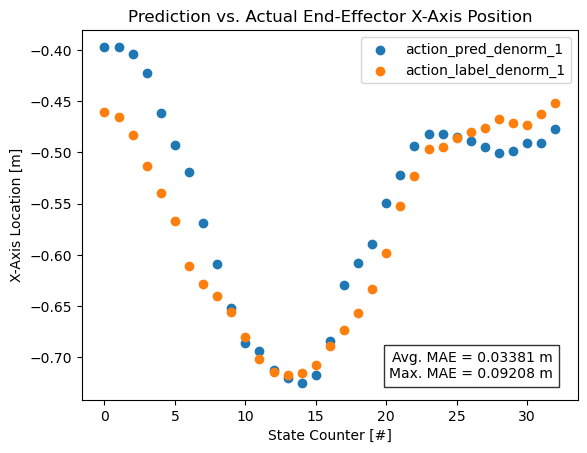

In [29]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

## Get Estimated Next States while Applying Trained Policy Model Action

In [30]:
# get all indice numbers where the new trajectory is initialized in the dataset
trajectory_indices = find_indices_of_trajectory_changes(dataset=all_test_data)

In [31]:
# index location where the each trajectory starts in the dataframe
traj_start_index = 0

trajectory_df = trajectory_estimation(configs=configs,
                                      updater_obj=updater,
                                      data_loader=all_test_data,
                                      policy_network=policy_network,
                                      trajectory_length=constants.TRAJECTORY_SIZE,
                                      traj_start_index=trajectory_indices[traj_start_index],
                                      is_inference=True)
trajectory_df

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_norm_4,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,state_est_denorm_4,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_norm_4,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_label_denorm_4,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_norm_4,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3,next_state_est_denorm_4
0,0.228150963783,0.726011872292,0.000000000000,0.409347295761,0.456301927567,1.452023744583,0.000000000000,0.818694591522,-0.133177444339,-0.212761536241,0.325091958046,-0.266354918480,-0.425523042679,0.650183916092,1.381720185280,1.382384657860,1.381953120232,-0.192030474544,-0.203344166279,0.328994721174,0.100192822516,0.100126273930,0.100169487298,-0.384060978889,-0.406688332558,0.657989501953,0,0,0.301948487759,0.228150963783,0.726011872292,0.000000000000,0.409347295761,0.456301927567,1.452023744583,0.000000000000,0.818694591522,0.228134945471,0.725997262622,0.000000000000,0.409341958046,0.456269890942,1.451994525243,0.000000000000,0.818683916092,0.210037656593,0.719072190312,0.059729369102,0.413244750977,0.420075313187,1.438144380624,0.119458738203,0.826489501953
1,0.228134974837,0.725997269154,0.000016527432,0.409341961145,0.456269949675,1.451994538307,0.000033054865,0.818683922291,-0.136032298207,-0.209825992584,0.328006982803,-0.272064566612,-0.419651985168,0.656013965607,1.381720185280,1.382384657860,1.381953120232,-0.236519217491,-0.176080286503,0.330962687731,0.100192822516,0.100126273930,0.100169487298,-0.473038434982,-0.352160573006,0.661925315857,0,1,0.305090248585,0.210037663579,0.719072163105,0.059729367495,0.413244754076,0.420075327158,1.438144326210,0.119458734989,0.826489508152,0.225212184923,0.725056509132,0.005026402178,0.412256982803,0.450424369846,1.450113018265,0.010052804356,0.824513965607,0.187749537927,0.700290697605,0.109815741607,0.415212657928,0.375499075854,1.400581395210,0.219631483214,0.830425315857
2,0.225212186575,0.725056529045,0.005035765469,0.412256985903,0.450424373150,1.450113058090,0.010071530938,0.824513971806,-0.156389713287,-0.196867644787,0.338062137365,-0.312779426575,-0.393735289574,0.676124334335,1.381720185280,1.382384657860,1.381953120232,-0.270579099655,-0.139512091875,0.331161171198,0.100192822516,0.100126273930,0.100169487298,-0.541158199310,-0.279024124146,0.662322282791,0,2,0.307190150023,0.187749534845,0.700290679932,0.109815739095,0.415212661028,0.375499069691,1.400581359863,0.219631478190,0.830425322056,0.210682972568,0.719357330001,0.030978224198,0.422312167168,0.421365945137,1.438714660002,0.061956448397,0.844624334335,0.165464358728,0.675191745321,0.155825315845,0.415411141396,0.330928717456,1.350383490642,0.311650631690,0.830822282791
3,0.210682958364,0.719357311726,0.030988903716,0.422312140465,0.421365916729,1.438714623451,0.061977807432,0.844624280930,-0.190853595734,-0.166184976697,0.350770950317,-0.381707191467,-0.332369923592,0.701541900635,1.381720185280,1.382384657860,1.381953120232,-0.301128268242,-0.097976736724,0.329547166824,0.100192822516,0.100126273930,0.100169487298,-0.602256536484,-0.195953488350,0.659094333649,0,3,0.307553142309,0.165464356542,0.675191760063,0.155825316906,0.415411144495,0.330928713083,1.350383520126,0.311650633812,0.830822288990,0.182052880639,0.702257709011

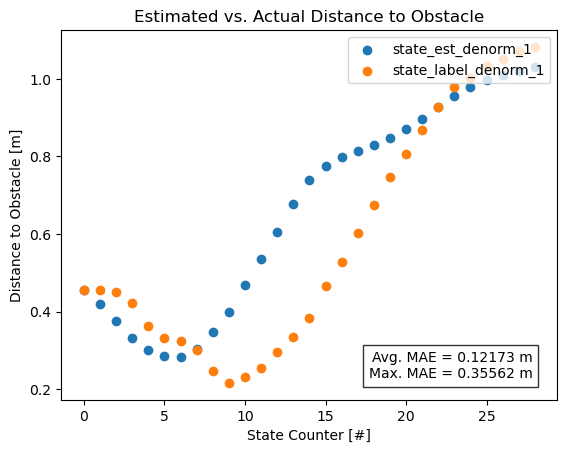

In [32]:
plt_2D_plotting(df=trajectory_df,
                column_names=[constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_1",
                              constants.STATE_DENORMALIZED_LABEL_NAME + "_1"],
                x_axis_name="State Counter [#]",
                y_axis_name="Distance to Obstacle [m]",
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name="Estimated vs. Actual Distance to Obstacle")

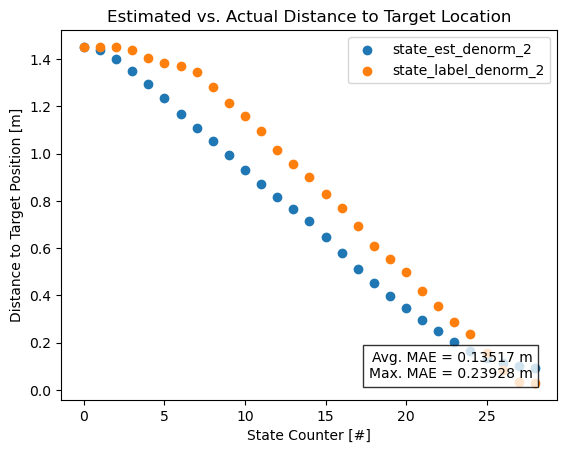

In [33]:
plt_2D_plotting(df=trajectory_df,
                column_names=[constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_2",
                              constants.STATE_DENORMALIZED_LABEL_NAME + "_2"],
                x_axis_name="State Counter [#]",
                y_axis_name="Distance to Target Position [m]",
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name="Estimated vs. Actual Distance to Target Location")

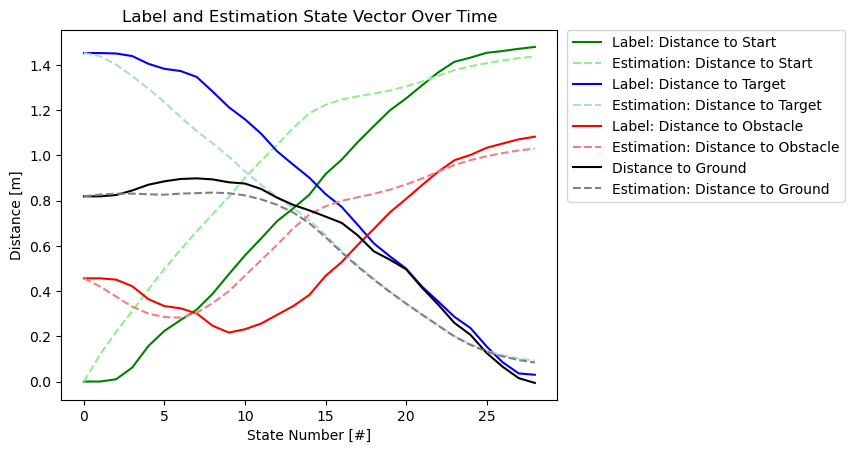

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

state_number_series = trajectory_df[constants.STATE_NUMBER_COLUMN]
state_label_df = trajectory_df[[
    constants.STATE_DENORMALIZED_LABEL_NAME + "_1",
    constants.STATE_DENORMALIZED_LABEL_NAME + "_2",
    constants.STATE_DENORMALIZED_LABEL_NAME + "_3",
    constants.STATE_DENORMALIZED_LABEL_NAME + "_4"
]]
state_estim_df = trajectory_df[[
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_1",
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_2",
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_3",
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_4"
]]

plot_label_estim_state(axs=[ax],
                       colors=["green", "blue", "red", "black", "lightgreen", "lightblue", "lightcoral", "gray"],
                       state_number_series=state_number_series,
                       label_data_df=state_label_df,
                       estim_data_df=state_estim_df)

ax.set_xlabel("State Number [#]")
ax.set_ylabel("Distance [m]")
ax.set_title("Label and Estimation State Vector Over Time")

ax.legend(bbox_to_anchor=(1.02, 1),
          loc="upper left", borderaxespad=0.0)

plt.show()

<IPython.core.display.Javascript object>


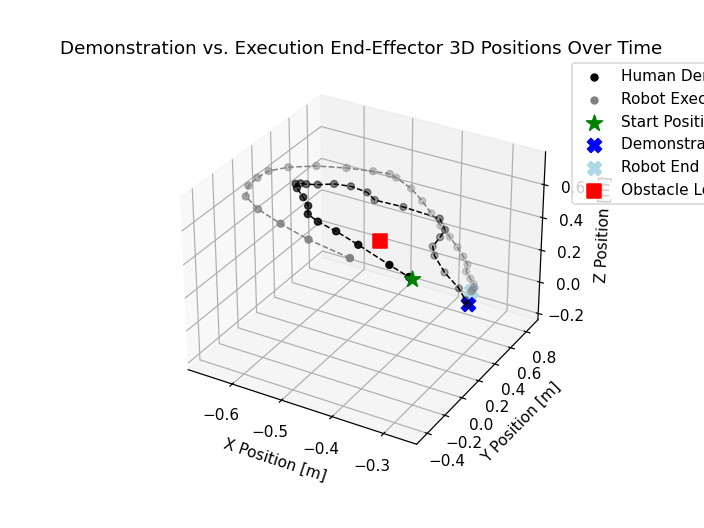

In [35]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

label_position_df = trajectory_df[[
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1",
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_2",
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_3"
]]
estim_position_df = trajectory_df[[
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_2",
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_3"
]]

plot_trajectory(ax=ax,
                label_trajectory_df=label_position_df,
                estim_trajectory_df=estim_position_df,
                object_position=constants.OBSTACLE_LOCATION,
                colors=["black", "grey"],
                traj_s=20,
                start_s=120,
                end_s=85)

ax.set_xlabel("X Position [m]")
ax.set_ylabel("Y Position [m]")
ax.set_zlabel("Z Position [m]")
ax.set_title("Demonstration vs. Execution End-Effector 3D Positions Over Time")

ax.legend(bbox_to_anchor=(1.02, 1),
          loc="upper left", borderaxespad=0.0)

plt.show()